In [1]:
import pynapple as nap
from pathlib import Path

In [2]:

nwb_path = Path("/data_store2/neuropixels/nwb/NP128_B1.nwb")
data = nap.load_file(nwb_path)

In [3]:
print(data)
spike_times = data["NP128_B1_g0_imec0_KS4"]

NP128_B1
┍━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Keys                        │ Type        │
┝━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ TaskTimes                   │ IntervalSet │
│ TaskStims                   │ IntervalSet │
│ StimSpeechWords             │ IntervalSet │
│ StimSpeechTrials            │ IntervalSet │
│ StimSpeechPhones            │ IntervalSet │
│ ProdSpeechWords             │ IntervalSet │
│ ProdSpeechTrials            │ IntervalSet │
│ ProdSpeechPhones            │ IntervalSet │
│ KilosortSortTimes           │ IntervalSet │
│ pitch                       │ TsdFrame    │
│ intensity                   │ TsdFrame    │
│ artics_new                  │ TsdFrame    │
│ NP128_B1_g0_imec1_KS4_Th=12 │ TsGroup     │
│ NP128_B1_g0_imec1_KS4       │ TsGroup     │
│ NP128_B1_g0_imec0_KS4_Th=12 │ TsGroup     │
│ NP128_B1_g0_imec0_KS4       │ TsGroup     │
│ TimeSeriesNIDQ              │ TsdFrame    │
│ ElectricalSeriesLFImec1     │ TsdFrame    │
│ ElectricalSeriesLFImec0

/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:60: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# print(spike_times)
KSLabels = spike_times.metadata["KSLabel_repeat"]
firingRates = spike_times.metadata["rate"]
contamPct = spike_times.metadata["ContamPct"]

mask1 = firingRates>0.5
mask2 = contamPct<10
mask3 = KSLabels=="good"
combined_mask = mask1 & mask2 & mask3
indices = firingRates[combined_mask].index

# now apply ISI violation criteria to narrow down good neurons
violationThreshold = 3/1000 #for 3 ms isi refractory period, lit standard
violationPct = np.zeros(len(indices))
ct = 0;
for i in indices:
    unit = spike_times[i]
    unit = unit.as_series().index
    isi = unit.diff()[1:len(unit)]
    violations = np.where(isi<violationThreshold)
    violations = np.array(violations)
    violationPct[ct] = violations.size/len(isi)
    ct += 1
# plt.hist(violationPct, bins = 20)
mask = violationPct<5/100 # throwing out neurons with > 3% isi violations
indicesFinal = indices[mask]
print(len(indicesFinal))
firingRates_final = firingRates[indicesFinal]
# plt.hist(firingRates_final, bins=20)

# early criteria for unit selection
# 1) firing rate > 0.5 ms [necessary for assembly code]
# 2) contamPct < 10%, maybe too liberal and can restrict after talking to Quinn prn
# 3) kilosort "good" 
# 4) isi violations < 5%, can check what I used before but should be fine
# 128_B1: 20


20


Feature means: [-2.07579684e-13 -2.71980244e-14 -1.97844060e-13 -8.04857209e-14
  1.13301951e-13  1.86902626e-13  1.12041231e-13 -3.08396556e-13
 -8.49130960e-14 -1.43558118e-14  7.95660508e-14  1.22608108e-13
 -1.87531916e-14  4.17875232e-14  2.32171616e-13  6.79390274e-14
 -5.12682440e-14 -2.98154498e-13 -2.93525359e-14  7.77820752e-14]
Feature stds: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Total variance: 19.999999999996128
Number of features: 20
Should match: 20


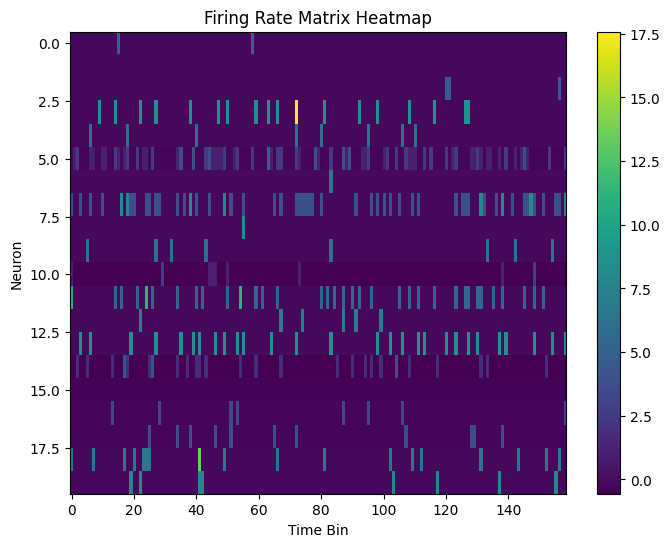

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# now restrict spike times to the good neurons
spike_times_good = spike_times[indicesFinal]
# print(spike_times_good)

# make spike count matrix
timescale = 25/1000;
spikeCountMatrix = spike_times_good.count(bin_size=timescale)
spikeCountMatrix = spikeCountMatrix.values # matrix in spike counts
firingRateMatrix = spikeCountMatrix/timescale # matrix in Hz
firingRateMatrix = stats.zscore(firingRateMatrix, axis=0) # zscore across time (within neuron)

# Verify standardization worked
print("Feature means:", np.mean(firingRateMatrix, axis=0))  # Should be ~0
print("Feature stds:", np.std(firingRateMatrix, axis=0))    # Should be ~1

# Check total variance
total_variance = np.sum(np.var(firingRateMatrix, axis=0))
print("Total variance:", total_variance)
print("Number of features:", firingRateMatrix.shape[1])
print("Should match:", firingRateMatrix.shape[1])

# visualize the first s seconds of the firing rate matrix
s = 4
matrixDisplay = firingRateMatrix[1:40*s,:]
plt.figure(figsize=(8, 6))
plt.imshow(matrixDisplay.T, aspect='auto', cmap='viridis')
plt.colorbar()
plt.xlabel('Time Bin')
plt.ylabel('Neuron')
plt.title('Firing Rate Matrix Heatmap')
plt.show()

Sum of eigenvalues: 20.000239581219063
Should equal total variance: 19.999999999996128
Original shape: (83480, 20)
PCA shape: (83480, 20)
Explained variance ratio: [0.09992722 0.06249568 0.05602631 0.05415859 0.0512818  0.05017199
 0.04960129 0.04893027 0.04833215 0.04796646 0.04736247 0.04662173
 0.04615589 0.04539491 0.04502527 0.04489972 0.0415079  0.03963002
 0.03752719 0.03698315]
Cumulative explained variance: [0.09992722 0.1624229  0.2184492  0.27260779 0.32388959 0.37406158
 0.42366287 0.47259314 0.52092529 0.56889175 0.61625422 0.66287595
 0.70903184 0.75442675 0.79945202 0.84435173 0.88585964 0.92548966
 0.96301685 1.        ]
1.0311962152471743
[1.99856836 1.24992853 1.12053953 1.08318476]


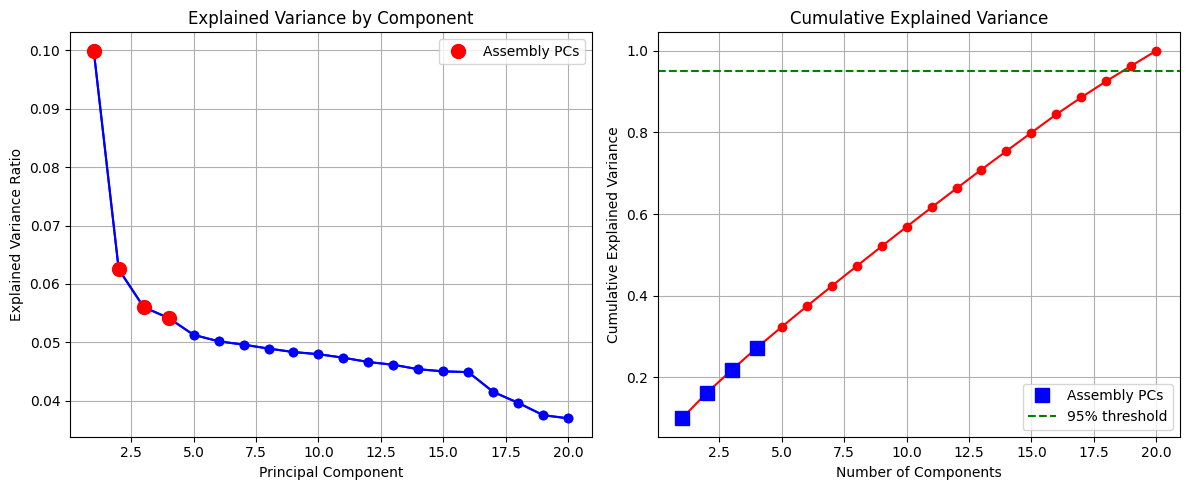

In [6]:
# now run pca on firing rate matrix
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# create PCA object
pca = PCA()

# fit and transform data
# note don't have to center bc each row is zscores so center of matrix is 0
firingRateMatrix_pca = pca.fit_transform(firingRateMatrix)

# Check eigenvalue sum
eigenvalues = pca.explained_variance_ 
print("Sum of eigenvalues:", np.sum(eigenvalues))
print("Should equal total variance:", total_variance)

# print results
print("Original shape:", firingRateMatrix.shape)
print("PCA shape:", firingRateMatrix_pca.shape)
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance:", np.cumsum(pca.explained_variance_ratio_))

# calculate the upperbound of the Marchenko-Pastur law, eigenvalues above the 
# upper bound are patterns that will be considered "assemblies"
upperbound = (1+np.sqrt(firingRateMatrix.shape[1]/firingRateMatrix.shape[0]))**2
assemblyIndices = np.where(eigenvalues>upperbound)
assemblyEigenvalues = eigenvalues[assemblyIndices]
print(upperbound)
print(assemblyEigenvalues)

# Plot explained variance
plt.figure(figsize=(12, 5))

# Plot 1: Explained variance ratio
plt.subplot(1, 2, 1)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_, 'bo-')
explained_var = pca.explained_variance_ratio_
plt.plot(range(1, len(explained_var) + 1), explained_var, 'bo-')
plt.plot(range(1, len(assemblyEigenvalues)+1), explained_var[:len(assemblyEigenvalues)], 'ro', markersize=10, label='Assembly PCs')
plt.legend()
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Component')
plt.grid(True)

# Plot 2: Cumulative explained variance
plt.subplot(1, 2, 2)
cumulative_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, 'ro-')
highlight_n = len(assemblyEigenvalues)
plt.plot(range(1, highlight_n + 1), cumulative_var[:highlight_n], 'bs', markersize=10, label='Assembly PCs')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Original projections shape: (83480, 4)
ICA components shape: (83480, 4)
Mixing matrix shape: (4, 4)
Unmixing matrix shape: (4, 4)
Reconstruction error: 2.8803410464872202e-31


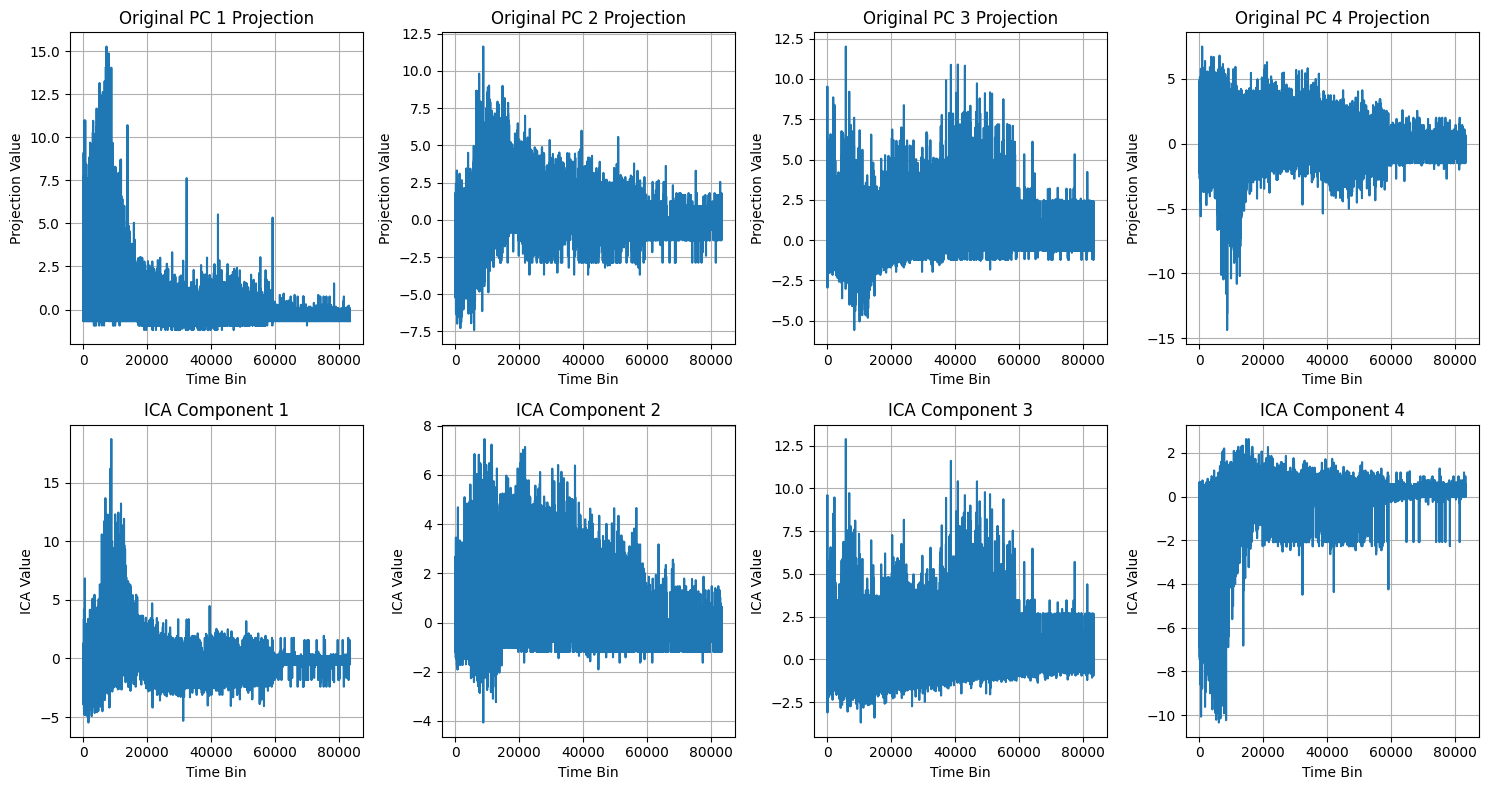


=== Statistical Comparison ===
Original PC projections:
PC 1: Skewness=3.380, Kurtosis=14.215
PC 2: Skewness=0.996, Kurtosis=5.872
PC 3: Skewness=2.262, Kurtosis=8.012
PC 4: Skewness=-0.118, Kurtosis=7.940

ICA components:
IC 1: Skewness=3.221, Kurtosis=23.676
IC 2: Skewness=1.594, Kurtosis=3.248
IC 3: Skewness=2.667, Kurtosis=10.435
IC 4: Skewness=-3.872, Kurtosis=18.448

=== Independence Check ===
ICA components correlation matrix:
[[ 1.00000000e+00 -1.79141374e-14 -5.25342427e-15  4.39813441e-14]
 [-1.79141374e-14  1.00000000e+00 -4.47382322e-14  1.27604896e-15]
 [-5.25342427e-15 -4.47382322e-14  1.00000000e+00 -8.85536866e-14]
 [ 4.39813441e-14  1.27604896e-15 -8.85536866e-14  1.00000000e+00]]

Original PC projections correlation matrix:
[[ 1.00000000e+00 -1.40664350e-15  5.76509504e-16  1.26621738e-15]
 [-1.40664350e-15  1.00000000e+00  1.05529942e-15  7.43358472e-16]
 [ 5.76509504e-16  1.05529942e-15  1.00000000e+00  7.68474224e-16]
 [ 1.26621738e-15  7.43358472e-16  7.68474224e

In [7]:
# now run ICA on PCA result
from sklearn.decomposition import FastICA
import numpy as np

# only get the assembly pca patterns
n_pcs = len(assemblyEigenvalues) # only want the above threshold patterns
pc_vectors = pca.components_[:n_pcs, :]

# project the assembly pca patterns onto the firing rate matrix
projections = firingRateMatrix @ pc_vectors.T

# visualize the assembly pattern activity across the recording
print(f"Original projections shape: {projections.shape}")

# define and run the ICA
fastica = FastICA(
    n_components=n_pcs,
    algorithm='parallel',
    whiten='unit-variance',
    max_iter=500,
    tol=1e-7,
    random_state=1
)
ica_components = fastica.fit_transform(projections)
print(f"ICA components shape: {ica_components.shape}")

# get mixing and unmixing matrices
mixing_matrix = fastica.mixing_
unmixing_matrix = fastica.components_
print(f"Mixing matrix shape: {mixing_matrix.shape}")
print(f"Unmixing matrix shape: {unmixing_matrix.shape}")

# Check reconstruction quality
reconstructed_projections = fastica.inverse_transform(ica_components)
reconstruction_error = np.mean((projections - reconstructed_projections)**2)
print(f"Reconstruction error: {reconstruction_error}")

# Visualize the original PC projections vs ICA components
fig, axes = plt.subplots(2, n_pcs, figsize=(15, 8))

# Plot original PC projections
for i in range(n_pcs):
    axes[0, i].plot(projections[:, i])
    axes[0, i].set_title(f'Original PC {i+1} Projection')
    axes[0, i].set_xlabel('Time Bin')
    axes[0, i].set_ylabel('Projection Value')
    axes[0, i].grid(True)

# Plot ICA components
for i in range(n_pcs):
    axes[1, i].plot(ica_components[:, i])
    axes[1, i].set_title(f'ICA Component {i+1}')
    axes[1, i].set_xlabel('Time Bin')
    axes[1, i].set_ylabel('ICA Value')
    axes[1, i].grid(True)
plt.tight_layout()
plt.show()

# Compare the statistical properties
print("\n=== Statistical Comparison ===")
print("Original PC projections:")
for i in range(n_pcs):
    skewness = stats.skew(projections[:, i])
    kurtosis = stats.kurtosis(projections[:, i])
    print(f"PC {i+1}: Skewness={skewness:.3f}, Kurtosis={kurtosis:.3f}")

print("\nICA components:")
for i in range(n_pcs):
    skewness = stats.skew(ica_components[:, i])
    kurtosis = stats.kurtosis(ica_components[:, i])
    print(f"IC {i+1}: Skewness={skewness:.3f}, Kurtosis={kurtosis:.3f}")

# Check independence (ICA should make components more independent)
print("\n=== Independence Check ===")
correlation_matrix = np.corrcoef(ica_components.T)
print("ICA components correlation matrix:")
print(correlation_matrix)

# Compare with original PC projections correlation
pc_correlation = np.corrcoef(projections.T)
print("\nOriginal PC projections correlation matrix:")
print(pc_correlation)


=== Strong Activation Analysis ===
IC 1: 4200 time points (5.0%) with strong activation
IC 2: 3982 time points (4.8%) with strong activation
IC 3: 4910 time points (5.9%) with strong activation
IC 4: 4324 time points (5.2%) with strong activation


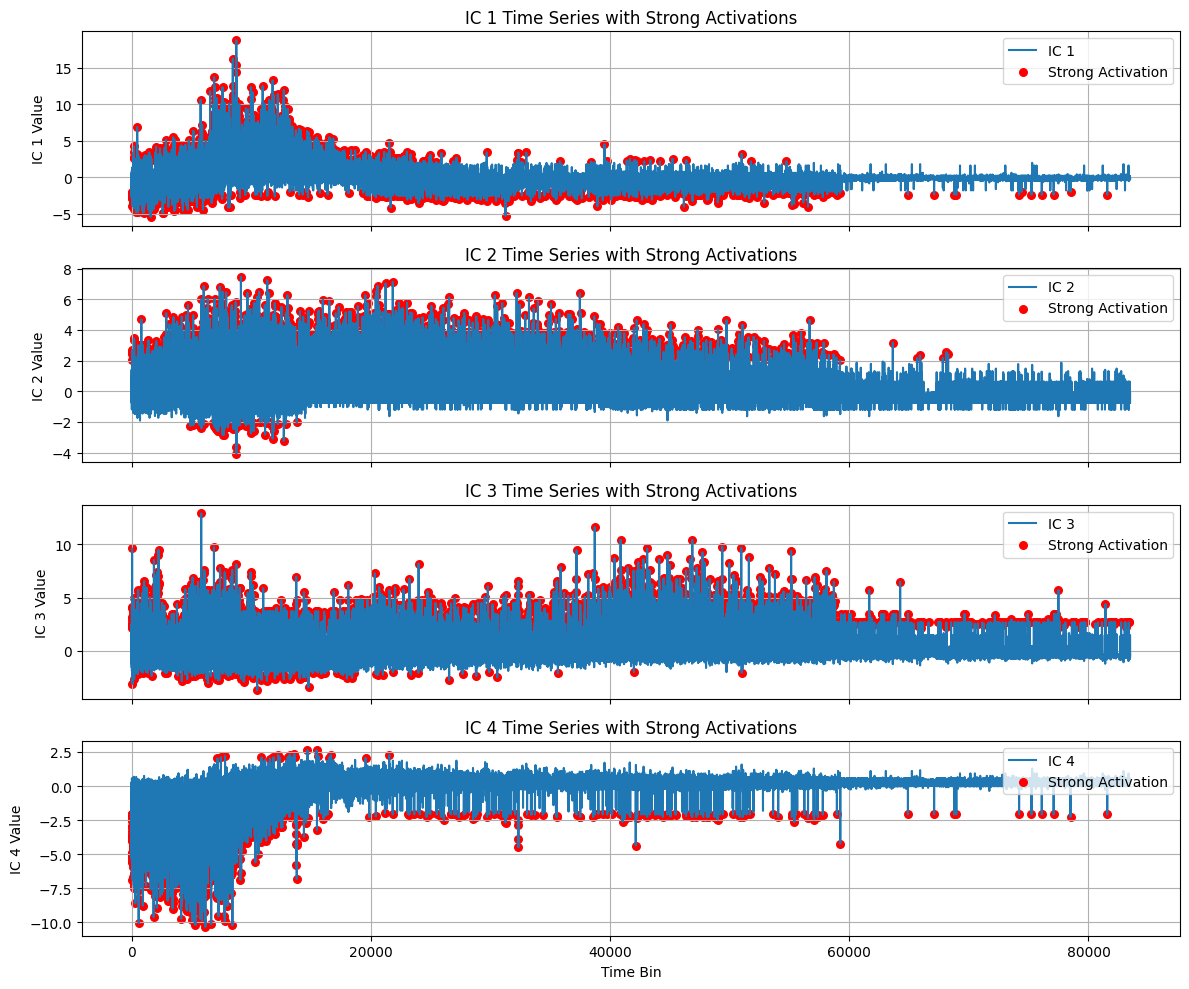

In [9]:
# Find time points with strong ICA component activation
threshold = np.std(ica_components, axis=0) * 2  # 2 standard deviations per component
strong_activation = np.abs(ica_components) > threshold

print(f"\n=== Strong Activation Analysis ===")
for i in range(n_pcs):
    n_strong = np.sum(strong_activation[:, i])
    percentage = 100 * n_strong / len(ica_components)
    print(f"IC {i+1}: {n_strong} time points ({percentage:.1f}%) with strong activation")

# Plot time series of each independent component with strong activations highlighted
fig, axes = plt.subplots(n_pcs, 1, figsize=(12, 2.5 * n_pcs), sharex=True)
if n_pcs == 1:
    axes = [axes]
time = np.arange(ica_components.shape[0])
for i in range(n_pcs):
    ax = axes[i]
    ax.plot(time, ica_components[:, i], label=f'IC {i+1}')
    # Highlight strong activations
    strong_idx = np.where(strong_activation[:, i])[0]
    ax.scatter(strong_idx, ica_components[strong_idx, i], color='red', s=30, label='Strong Activation')
    ax.set_ylabel(f'IC {i+1} Value')
    ax.set_title(f'IC {i+1} Time Series with Strong Activations')
    ax.grid(True)
    ax.legend(loc='upper right')
axes[-1].set_xlabel('Time Bin')
plt.tight_layout()
plt.show()



ICA assembly patterns shape: (4, 20)


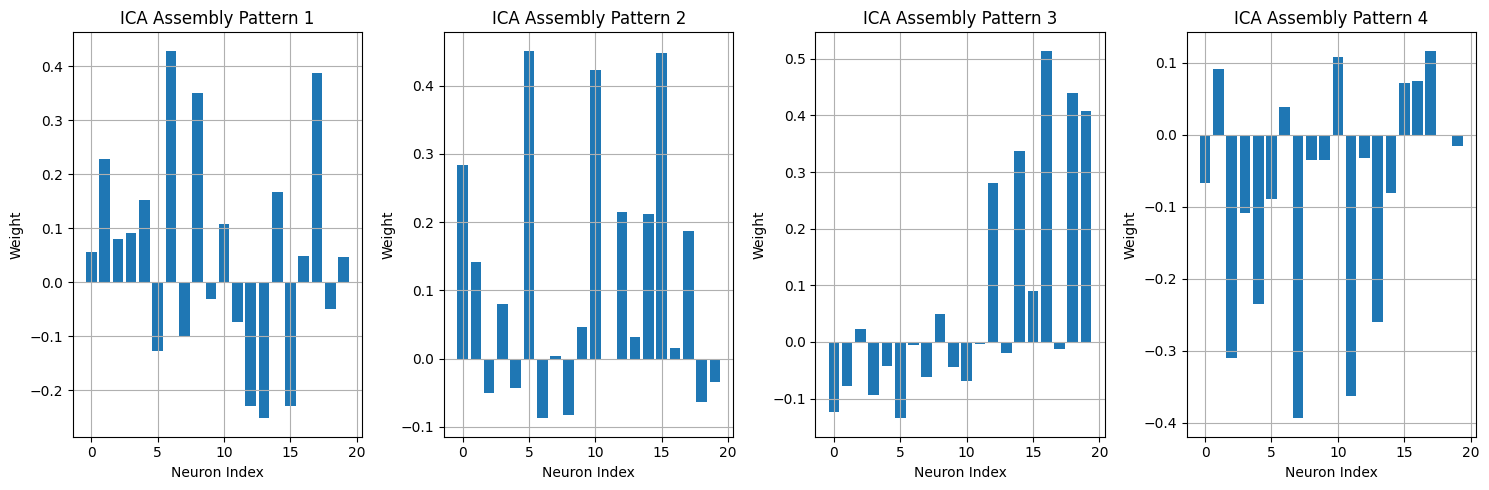

[[0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1.]
 [0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]]


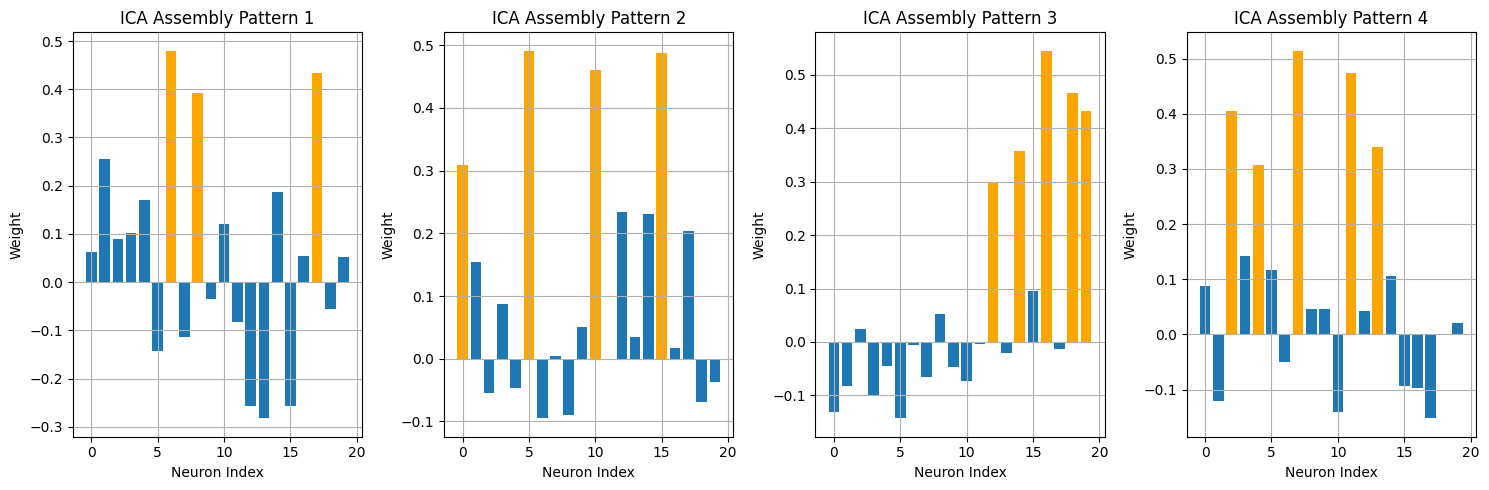

In [10]:
# Project ICA components back to original feature space
# This gives you the neural assembly patterns in the original neuron space
from scipy.linalg import norm

ica_assembly_patterns = unmixing_matrix @ pc_vectors  # Shape: (n_pcs, n_features)

print(f"\nICA assembly patterns shape: {ica_assembly_patterns.shape}")

# Visualize the ICA assembly patterns
plt.figure(figsize=(15, 5))
for i in range(n_pcs):
    plt.subplot(1, n_pcs, i+1)
    plt.bar(range(ica_assembly_patterns.shape[1]), ica_assembly_patterns[i, :])
    plt.title(f'ICA Assembly Pattern {i+1}')
    plt.xlabel('Neuron Index')
    plt.ylabel('Weight')
    plt.grid(True)
plt.tight_layout()
plt.show()

ap_norm_matrix = ica_assembly_patterns
ap_norm_member = np.zeros(ica_assembly_patterns.shape)
for i in range(n_pcs):
    ap = ica_assembly_patterns[i,:]
    ap_norm = ap/norm(ap)
    maxW = max(ap_norm);
    minW = min(ap_norm);
    if abs(minW) > maxW:
        ap_norm = ap_norm*-1
    ap_norm_matrix[i,:] = ap_norm
    threshold = np.mean(ap_norm) + np.std(ap_norm)
    for c in range(len(ap)):
        if ap_norm[c] > threshold:
            ap_norm_member[i,c] = 1
            
print(ap_norm_member)

# Visualize the ICA assembly patterns
plt.figure(figsize=(15, 5))
for i in range(n_pcs):
    plt.subplot(1, n_pcs, i+1)
    plt.bar(range(ap_norm_matrix.shape[1]), ap_norm_matrix[i, :])
    member_indices = np.where(ap_norm_member[i, :] == 1)[0]
    plt.bar(member_indices, ap_norm_matrix[i, member_indices], color='orange')
    plt.title(f'ICA Assembly Pattern {i+1}')
    plt.xlabel('Neuron Index')
    plt.ylabel('Weight')
    plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# read in files for cell depth and waveform
